<a href="https://colab.research.google.com/github/samkirwanppb/UCDPA_SamKirwan/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
##importing all packages needed for this project
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid") ### might have to put this into the function below. we will see in time. 
sns.color_palette("Spectral", as_cmap=True) #this changes the relplot, hue is different in the lm plot
sns.set()

# Data Gathering/Cleaning

In [55]:
##the ratings data set contains the current ratings of all horses trained in Great Britain
ratings = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/ratings.csv')
ratings = ratings.iloc[:, :-7] 
ratings['rating_final'] = ratings[['Flat rating', 'AWT rating']].max(axis = 1) #gets the max rating of the 2 available ratings for a horse and creats and new column
ratings.loc[ratings['Flat rating'].notnull() & ratings['AWT rating'].notnull()].head() #the column on the right contains the max of the 2 columns that we are interested in.

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,Diff AWT,rating_final
34,ABOVE (FR),2017,GELDING,ANJAAL (GB),BROKEN APPLAUSE (IRE),Stuart Williams,89.0,NaN,NaN,94.0,NaN,94.0
155,AIR RAID (GB),2015,GELDING,RAVEN'S PASS (USA),SIREN SOUND (GB),NaN,94.0,NaN,NaN,89.0,NaN,94.0
182,AL KOUT (GB),2014,GELDING,OASIS DREAM (GB),HONORLINA (FR),NaN,61.0,NaN,NaN,67.0,NaN,67.0
196,AL ZARAQAAN (GB),2017,GELDING,GOLDEN HORN (GB),ASHEERAH (GB),Archie Watson,87.0,NaN,NaN,102.0,NaN,102.0
204,ALBA DEL SOLE (IRE),2015,FILLY,DANDY MAN (IRE),WINTERWELL (USA),NaN,49.0,NaN,NaN,42.0,NaN,49.0


In [56]:
ratings = ratings.drop(columns = {'Diff Flat', 'Flat Clltrl', 'Diff AWT', 'Flat rating', 'AWT rating'}) #removing unwanted columns
ratings.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0


In [57]:
###will use the above data to see how many horses a particular trainer has in training. this metric will also be used to predict horse ability. 
trainer = pd.DataFrame()

trainer = ratings.groupby('Trainer')['Name'].count().rename('trainer_horses').reset_index()
trainer.head()

,Trainer,trainer_horses
0,A C Wilson,1
1,A. B. Leyshon,2
2,Adam Nicol,8
3,Adam West,25
4,Adrian Keatley,19


In [58]:
ratings_trainer = ratings.merge(trainer, on = 'Trainer', how = 'left')
ratings_trainer.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,69.0
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,90.0
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN


In [59]:
##performance_ratings will be used to see if a horse has had 1,2,3,4,5 or 6+ runs
performance_figures = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/performance_figures.csv')
##remove National Hunt ratings. #meh will come back to it, not sure will I need this table really. 
performance_figures.head()

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,T:73,T:79,T:72,T:63,T:74,T:80
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,A:42,T:47,T:x,T:x,T:x,-
2,A DEFINITE GETAWAY (IRE),2018,GELDING,Ben Pauling,H:x,H:x,H:x,-,-,-
3,A DIFFERENT KIND (IRE),2017,GELDING,Donald McCain,H:93,H:135,H:x,H:x,H:x,H:x
4,A E HOUSMAN (GB),2019,COLT,NaN,T:71,A:x,A:x,T:x,T:x,-


In [60]:
##this function is used to remove the unwanted charactors from the df.
def clean_peformance_figures(data, column):  
  data = data[~data[column].str.contains("H")]
  data = data[~data[column].str.contains("S")]
  data = data[~data[column].str.contains("N")]
  data[column] = data[column].str.replace(":","").str.replace("T", "").str.replace("A","")
  return data

#this for loop iterates through the last 6 columns of the data and passes them into the function created to clean the columns.
for i in performance_figures.columns[-6:]:
  performance_figures = clean_peformance_figures(performance_figures, i)

performance_figures = performance_figures.replace("-", np.nan)
performance_figures['runs'] = 6 - performance_figures.iloc[:,-6:].isna().sum(axis = 1)
performance_figures.head() #we havce succesfully created the runs column which will be used in the model. 

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,73,79,72,63,74,80,6
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,42,47,x,x,x,NaN,5
4,A E HOUSMAN (GB),2019,COLT,NaN,71,x,x,x,x,NaN,5
5,A LA FRANCAISE (GB),2019,FILLY,Jim Goldie,61,71,65,61,50,63,6
6,A LADY FOREVER (GB),2019,FILLY,Robyn Brisland,x,x,x,x,NaN,NaN,4


In [61]:
##I have merged ratings and the columns I want from peformance figures here
ratings_merged = ratings_trainer.merge(performance_figures[['Racehorse', 'runs']], left_on = 'Name', right_on = 'Racehorse').drop(columns = 'Racehorse')
ratings_merged.loc[(~ratings_merged['rating_final'].isna()) & (ratings_merged['runs'] <= 2), 'runs'] = np.nan ##this removes funny examples where horses where imported into GB already with a rating
ratings_merged.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0


In [62]:
yearling_sales = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales.csv').drop(columns = 'Purchaser')
yearling_sales.head()

,Year Foaled,Sire,Dam,Sex,Consignor,Price (€),Price (£),Price (gns)
0,2020.0,Lope de Vega (IRE),Ebeyina (IRE),Colt,Ballylinch Stud,130000.0,NaN,NaN
1,2020.0,U S Navy Flag (USA),Edelline (IRE),Colt,Lynn Lodge Stud,36000.0,NaN,NaN
2,2020.0,Holy Roman Emperor (IRE),Elaysa (GB),Colt,Redpender Stud,90000.0,NaN,NaN
3,2020.0,No Nay Never (USA),Eldalil (GB),Filly,Oaks Farm Stables,85000.0,NaN,NaN
4,2020.0,Churchill (IRE),Elizabelle (IRE),Filly,Baroda Stud,60000.0,NaN,NaN


In [63]:
#Data cleansing to merge into the main dataframe
yearling_sales['Sire'] = yearling_sales['Sire'].str.upper()
yearling_sales['Dam'] = yearling_sales['Dam'].str.upper()
yearling_sales['Sex'] = yearling_sales['Sex'].str.upper()
yearling_sales = yearling_sales.dropna(subset = ['Year Foaled'])
yearling_sales['Year Foaled'] = yearling_sales['Year Foaled'].astype(int)

##going to get them all in the one currency
yearling_sales.loc[~yearling_sales['Price (€)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (€)'].isna()]['Price (€)'] * 0.88
yearling_sales.loc[~yearling_sales['Price (gns)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (gns)'].isna()]['Price (gns)'] * 1.05
yearling_sales.loc[~yearling_sales['Price (£)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (£)'].isna()]['Price (£)'] * 1
yearling_sales = yearling_sales.drop(columns = ['Price (€)', 'Price (£)', 'Price (gns)'])
yearling_sales.head()

<ipython-input-63-b8f1f41d6b38>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearling_sales['Year Foaled'] = yearling_sales['Year Foaled'].astype(int)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,Year Foaled,Sire,Dam,Sex,Consignor,final_sale_price
0,2020,LOPE DE VEGA (IRE),EBEYINA (IRE),COLT,Ballylinch Stud,114400.0
1,2020,U S NAVY FLAG (USA),EDELLINE (IRE),COLT,Lynn Lodge Stud,31680.0
2,2020,HOLY ROMAN EMPEROR (IRE),ELAYSA (GB),COLT,Redpender Stud,79200.0
3,2020,NO NAY NEVER (USA),ELDALIL (GB),FILLY,Oaks Farm Stables,74800.0
4,2020,CHURCHILL (IRE),ELIZABELLE (IRE),FILLY,Baroda Stud,52800.0


In [64]:
ratings_final_sale = ratings_merged.merge(yearling_sales.drop(columns = ['Sex','Consignor']), left_on = ['Sire', 'Dam', 'Year'], right_on = ['Sire', 'Dam', 'Year Foaled'], how = 'left')
ratings_final_sale = ratings_final_sale.drop(columns = 'Year Foaled')
ratings_final_sale.head()##note final price is in £

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN


In [65]:
yearling_sales_sires = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales_sires.csv')
median_yearling_sales = yearling_sales_sires.loc[yearling_sales_sires['year'] == 2022][['Stallion', 'Med. £']]
median_yearling_sales['Stallion'] = median_yearling_sales['Stallion'].str.capitalize() ##funny examples of Lope de Vega where some are capitals and some arnt. sire_merge uses capitize so best to use that here too
median_yearling_sales.head() ##the stallion name is formated different to the ratings_final_sale df which I will have to clean in order to merge

,Stallion,Med. £
0,Dubawi,"669,375"
3,Frankel,"338,123"
4,Kingman,"283,500"
5,Galileo,"259,307"
7,Siyouni,"181,741"


In [66]:
ratings_final_sale['sire_merge'] = ratings_final_sale['Sire'].str.split("(").str[0].str.strip().str.capitalize()
ratings_final_sale.head() #sire_merge can be used to merge the above df into the main one

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay


In [67]:
merged_data = ratings_final_sale.merge(median_yearling_sales, left_on = 'sire_merge', right_on = 'Stallion', how = 'left').replace(',','', regex=True)
merged_data = merged_data.drop(columns = ['Stallion']).rename(columns = {'Med. £' : 'Sire_median_yearling_price'})#makes the median price more readable
merged_data['Sire_median_yearling_price'] = merged_data['Sire_median_yearling_price'].astype(float)
merged_data.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0


# Data Cleaning / Web Scraping


In [68]:
###start of scraping the below site was found after inspecting the irish field website
hsite = "https://e.infogram.com/_/bQHbMUkcBdD1LFGscrW5?parent_url=https%3A%2F%2Fwww.theirishfield.ie%2Fstallion-fees-up-to-date-fees-for-more-than-400-stallions-for-2023-738173&src=embed#async_embed"
res = requests.get(hsite)
soup = bs(res.content, "html.parser")
#soup


x = soup.find_all("script")[4]
## really good use of regex here i think to get the data from there.

string = str(x)
print(string[0:2000])###dont print all of it, looks bad in github

<script>window.infographicData={"id":318959736,"type":0,"block_id":"023467ec-1db7-4ba5-90b3-12e78f43dcf4","theme_id":258,"user_id":2114665,"team_user_id":805284,"path":"a0ff400d-32c4-4e46-bde8-a093a04e1b11","title":"Stallion fees 2023 wk48","description":"","tags":"","public":false,"publicAccess":false,"private_link_enabled":1,"thumb":"https:\u002F\u002Finfogram-thumbs-200.s3-eu-west-1.amazonaws.com\u002F023467ec-1db7-4ba5-90b3-12e78f43dcf4.jpg","embedImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F6c657eaada927282c6ba8f94485caba4.png","previewImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F90c07788e8331dd681e583525fa6ab72.png","width":599,"copyright":"","properties":{"tabs":true,"custom_logo":"none","embed_button":"disabled","transparent":true,"zeropaddingembed":"true","title_link":"infogram","customLinkOption":"text","footerSettings":{},"publishType":1,"rtl":false,"language":"en","export_settings":{"showGrid":true,"showValues":true},"whitelabel":true,"noTracking":false,"dec

In [69]:
raw_data = re.findall(r'\[(.*?)\]', string)


##the below is a reusable function. When inputting the list returned from the regex pattern this will return the desired elements that we would like to keep
def clean_data(data):
  data_filtered = []
  for i in data:
    if len(i) != 0: ##removes empty strings in the list 
        if i[0] == '"' and i[-2:] == ')"': ##these are the charactorists of the strings that we want to keep.
            i = i.replace('"', '')#removing all the "'s from the data
            data_filtered.append(i)

  return data_filtered

data_lst = clean_data(raw_data)

print(data_lst[0:5])

['Acclamation,Rathbarry,€27,500 (€27,500)', 'Alkumait,Castlefield,€5,000 (€5,000)', 'Arizona,Coolmore,€5,000 (€6,000)', 'Australia,Coolmore,€25,000 (€35,000)', 'Awtaad,Derrinstown,€5,000 (€5,000)']


In [70]:
data_dic = {}
for i in data_lst:
  data_dic[i.split(",", 2)[0]] = [i.split(",", 2)[1],i.split(",", 2)[2]]

col = ['Sire','Stud', 'Fee']
fee_data = pd.DataFrame.from_dict(data_dic, orient='index').reset_index()
fee_data.set_axis(col, axis = 1, inplace = True)
fee_data.head()

,Sire,Stud,Fee
0,Acclamation,Rathbarry,"€27,500 (€27,500)"
1,Alkumait,Castlefield,"€5,000 (€5,000)"
2,Arizona,Coolmore,"€5,000 (€6,000)"
3,Australia,Coolmore,"€25,000 (€35,000)"
4,Awtaad,Derrinstown,"€5,000 (€5,000)"


In [71]:
##cleaning the fee column. the first price is the 2023 years fee, the price in brackets is the 2022 fee (last year)
fee_data['Fee 2023'] = fee_data['Fee'].str.split("(").str[0].str.strip()
fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('A\$'))]#remove australian stallions, had to use the escape charactor for the dollar sign, in plain english we are removing strings containing A$
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('Private'))]
fee_data.head()

<ipython-input-71-424f868148fe>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")


,Sire,Stud,Fee,Fee 2023,Fee 2022
0,Acclamation,Rathbarry,"€27,500 (€27,500)","€27,500","€27,500"
1,Alkumait,Castlefield,"€5,000 (€5,000)","€5,000","€5,000"
2,Arizona,Coolmore,"€5,000 (€6,000)","€5,000","€6,000"
3,Australia,Coolmore,"€25,000 (€35,000)","€25,000","€35,000"
4,Awtaad,Derrinstown,"€5,000 (€5,000)","€5,000","€5,000"


In [72]:
fee_data['Fee 2022'].value_counts().head() ##shows this akward that is there as new

NEW        34
€5,000     22
$10,000    16
€15,000    10
€4,000      9
Name: Fee 2022, dtype: int64

In [73]:
#replacing the new value with nans
fee_data['Fee 2022'] = fee_data['Fee 2022'].replace('NEW', np.nan)
fee_data['Fee 2022'].value_counts().head()#new is gone and replaced with NP.nan

€5,000     22
$10,000    16
€15,000    10
€4,000      9
$15,000     8
Name: Fee 2022, dtype: int64

In [74]:
##careful reruning this, if no fee has changed currency can use the following - fee_data[['Currency 2023', 'Currency 2022']] = fee_data['Fee'].str[0] 
##as can be seen in the above code the fee columns still need some cleaning. also an important observation is that the currencyies for the fees are different for certain stallions
#so I will create a column that stores the currencies so that we can convert them all into the one
fee_data['Currency 2023'] = fee_data['Fee 2023'].str[0] 
fee_data['Currency 2022'] = fee_data['Fee 2022'].str[0]
#clean the Fee 2022 and Fee 2023 columns so that they are ints
fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data = fee_data.replace(',','', regex=True)


<ipython-input-74-a1469e21d690>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
<ipython-input-74-a1469e21d690>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")


In [75]:
fee_data[['Fee 2022','Fee 2023']] = fee_data[['Fee 2022','Fee 2023']].astype(float)

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '€'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.88
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '€'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.88

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '$'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.83
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '$'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.83

fee_data[['Fee 2022', 'Fee 2023']] = fee_data[['Fee 2022', 'Fee 2023']].fillna(0).astype(int).replace(0, np.nan)
fee_data.head() #have clean data scraped from the web in the formate that we require

,Sire,Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022,Fee_2023_final,Fee_2022_final
0,Acclamation,Rathbarry,€27500 (€27500),27500,27500.0,€,€,24200.0,24200.0
1,Alkumait,Castlefield,€5000 (€5000),5000,5000.0,€,€,4400.0,4400.0
2,Arizona,Coolmore,€5000 (€6000),5000,6000.0,€,€,4400.0,5280.0
3,Australia,Coolmore,€25000 (€35000),25000,35000.0,€,€,22000.0,30800.0
4,Awtaad,Derrinstown,€5000 (€5000),5000,5000.0,€,€,4400.0,4400.0


In [76]:
fee_data = fee_data[['Sire', 'Fee_2023_final']]#keeping the columns we need for the main data set
fee_data.head()

,Sire,Fee_2023_final
0,Acclamation,24200.0
1,Alkumait,4400.0
2,Arizona,4400.0
3,Australia,22000.0
4,Awtaad,4400.0


In [77]:
##have moved down here for when i merge in sire fee
data = merged_data.merge(fee_data, left_on = 'sire_merge', right_on = 'Sire', how = 'left').drop(columns = 'Sire_y').rename(columns = {'Sire_x': 'Sire'})
data.head() ##we now have a clean data set containing all the columns from each data set that we desire.            

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0,4400.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0,NaN
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0,4400.0


In [78]:
data.shape

(7478, 13)

# Dataset Description/Overview

In [79]:
##do some descriptive stuff here off final dataset
data.shape, data.columns

((7478, 13),
 Index(['Name', 'Year', 'Sex', 'Sire', 'Dam', 'Trainer', 'rating_final',
        'trainer_horses', 'runs', 'final_sale_price', 'sire_merge',
        'Sire_median_yearling_price', 'Fee_2023_final'],
       dtype='object'))

In [131]:
data.describe()

,Year,rating_final,trainer_horses,runs,final_sale_price,Sire_median_yearling_price,Fee_2023_final
count,7478.000000,7458.000000,4975.000000,7340.000000,2.670000e+03,5052.000000,1455.000000
mean,2018.328698,69.032046,37.964623,5.384469,6.726686e+04,67020.989311,24762.529210
std,1.678526,17.782760,28.337289,1.082698,1.349855e+05,111324.632717,27186.441242
min,2009.000000,10.000000,1.000000,0.000000,8.400000e+02,2822.000000,880.000000
25%,2018.000000,56.000000,16.000000,5.000000,1.680000e+04,17042.000000,6600.000000
50%,2019.000000,68.000000,31.000000,6.000000,3.675000e+04,34205.000000,20750.000000
75%,2019.000000,80.000000,51.000000,6.000000,7.447500e+04,52500.000000,35200.000000
max,2020.000000,124.000000,123.000000,6.000000,3.780000e+06,669375.000000,186750.000000


In [80]:
data[['Year', 'rating_final',
        'trainer_horses', 'runs', 'final_sale_price',
        'Sire_median_yearling_price', 'Fee_2023_final']].corr() #can see the biggest correlation with rating final is trainer_horses, final_sale_price and sire_median_yearling_price

,Year,rating_final,trainer_horses,runs,final_sale_price,Sire_median_yearling_price,Fee_2023_final
Year,1.000000,0.038402,0.111753,-0.400560,-0.040172,-0.041065,-0.052636
rating_final,0.038402,1.000000,0.219353,0.009096,0.259335,0.264036,0.152809
trainer_horses,0.111753,0.219353,1.000000,-0.072829,0.058183,0.055977,0.026190
runs,-0.400560,0.009096,-0.072829,1.000000,-0.054189,-0.031725,0.012342
final_sale_price,-0.040172,0.259335,0.058183,-0.054189,1.000000,0.508414,0.270495
Sire_median_yearling_price,-0.041065,0.264036,0.055977,-0.031725,0.508414,1.000000,0.982899
Fee_2023_final,-0.052636,0.152809,0.026190,0.012342,0.270495,0.982899,1.000000


In [81]:
data.isna().sum() #we can see that there is alot of missing values for final_price. which 

Name                             0
Year                             0
Sex                              0
Sire                             0
Dam                              0
Trainer                       2503
rating_final                    20
trainer_horses                2503
runs                           138
final_sale_price              4808
sire_merge                       0
Sire_median_yearling_price    2426
Fee_2023_final                6023
dtype: int64

In [82]:
##The aim of this project will be to use supervised learning to predict a horses ability. A horses ability is represented by its rating. A horse that has a higher rating is a better horse then a horse with a lower rating

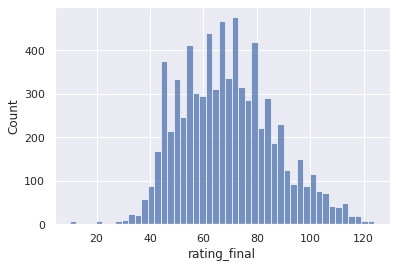

In [83]:
##EDA of rating_final variable (horse_ability)
sns.histplot(data = data, x = 'rating_final')
##The data is largely normaly distributed. there is a hint of it being skewed to the right

In [84]:
data['rating_final'].max(), data['rating_final'].min() #cam see there is some outliers rated 10

(124.0, 10.0)

In [85]:
data.loc[data['rating_final'] < 20]

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final
2635,GO BUNNY (IRE),2020,FILLY,NATIONAL DEFENSE (GB),TYPIFY (GB),NaN,10.0,NaN,3.0,NaN,National defense,6278.0,NaN
2932,HEIDI OF ARENDELLE (GB),2020,FILLY,OUTSTRIP (GB),PRINCESS HEIDI (IRE),Derek Shaw,10.0,27.0,3.0,NaN,Outstrip,4333.0,NaN
2959,HERMAN THE GERMAN (IRE),2019,GELDING,THE CARBON UNIT (USA),STORMINATEACUP (IRE),NaN,10.0,NaN,4.0,NaN,The carbon unit,NaN,NaN
3715,LANZAROTE SUNSHINE (GB),2017,FILLY,MUSIC MASTER (GB),BASLE (GB),NaN,10.0,NaN,3.0,NaN,Music master,NaN,NaN
4548,MR QUIGLEY (GB),2019,GELDING,IFFRAAJ (GB),WHITE ROSA (IRE),NaN,10.0,NaN,4.0,NaN,Iffraaj,34650.0,NaN
5560,RIDE SALLY RIDE (GB),2019,FILLY,RULER OF THE WORLD (IRE),NOBLE PENNY (GB),NaN,10.0,NaN,3.0,NaN,Ruler of the world,8677.0,NaN
6308,SQUIRE STREET (IRE),2019,GELDING,RULER OF THE WORLD (IRE),LARA CARBONARA (IRE),NaN,10.0,NaN,3.0,NaN,Ruler of the world,8677.0,NaN


In [86]:
# # Create bee swarm plot
# sns.swarmplot(data=data, x='Sex', y='rating_final')

# # Label the axes
# plt.xlabel('Sex')
# plt.ylabel('rating_final')

# # Show the plot
# plt.show()

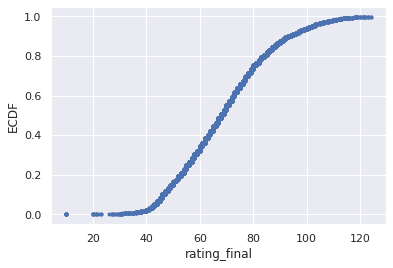

In [87]:
##ecf function taken from datacamp module
#using on rating_final
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y
  
  # Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(data['rating_final'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('rating_final')
plt.ylabel('ECDF')

# Display the plot
plt.show()

# Creting an est final price column

In [88]:
## in order to reduce the number of nans in the final_price column I will use trainers average purchase price to est how much a yearling would have made. 
avg_trainer_price = data.groupby('Trainer')['final_sale_price'].agg({'median', 'count'}).rename(columns = {'median':'median_trainer_price', 'count': 'count_trainer_price'})
avg_trainer_price.head(), avg_trainer_price.shape, avg_trainer_price.loc[avg_trainer_price['count_trainer_price'] > 5].shape ##come up with a plan on trainer avg here. will merge in below.

(                 median_trainer_price  count_trainer_price
 Trainer                                                   
 Adam Nicol                    31500.0                    1
 Adam West                     15810.0                    6
 Adrian Keatley                20000.0                    7
 Adrian Nicholls               21560.0                    6
 Adrian Wintle                 20520.0                    6,
 (381, 2),
 (109, 2))

In [89]:
data_df = data.merge(avg_trainer_price, how = 'left', on = 'Trainer')
data_df.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,median_trainer_price,count_trainer_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0,4400.0,4725.0,5.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0,NaN,NaN,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0,NaN,35000.0,8.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0,4400.0,5170.0,10.0


In [90]:
##finally to get the estimate i will take the avergae of the median sire yealing price and the trainer price.
data_df['final_sale_price_est'] = data_df[['median_trainer_price', 'Sire_median_yearling_price']].mean(axis=1) ##sire_median_yearling price is the wrong data type.

In [91]:
## as final_price is the main metric i am going to overrite the est column with the values we already had.
data_df.loc[~data_df['final_sale_price'].isna(), 'final_sale_price_est'] = data_df.loc[~data_df['final_sale_price'].isna()]['final_sale_price']

In [92]:
data_df.isna().sum() #we know only have 831 missing values for final_sale_price_est

Name                             0
Year                             0
Sex                              0
Sire                             0
Dam                              0
Trainer                       2503
rating_final                    20
trainer_horses                2503
runs                           138
final_sale_price              4808
sire_merge                       0
Sire_median_yearling_price    2426
Fee_2023_final                6023
median_trainer_price          2806
count_trainer_price           2503
final_sale_price_est           831
dtype: int64

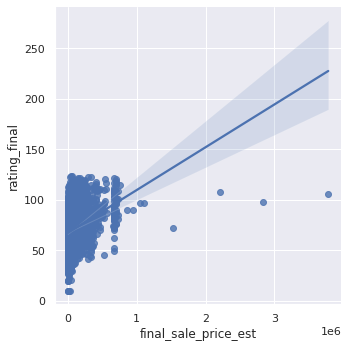

In [93]:
##eda of new final_sale_price_est column
sns.lmplot(data = data_df, x = 'final_sale_price_est', y = 'rating_final')

In [94]:
#we can also see in the above graph that final_sale_price_est has 4 outliers that cose more then 1,200,000. If we were to included these in the model the predicted final rating would be way over the max 130.
#should probably do a bit on testing the outliers effecting the model.
data_df = data_df.loc[data_df['final_sale_price_est'] < 1200000]


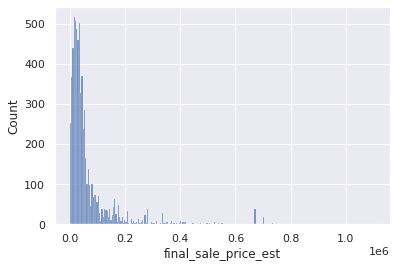

In [97]:
sns.histplot(data = data_df, x = 'final_sale_price_est') # can see data is skewed like most price distributions. the majority of horses are sold for less then 0.5 million

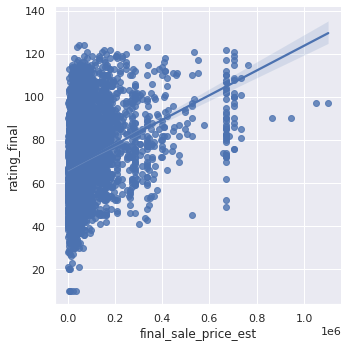

In [95]:
##eda of new final_sale_price_est column without outliers
sns.lmplot(data = data_df, x = 'final_sale_price_est', y = 'rating_final') 

In [110]:
##person correltaion stats.
def pearson_r(x,y):
    ##"""Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef([x,y])

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient for I. versicolor: r
data_df_no_nans = data_df.loc[~(data_df['final_sale_price_est'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['final_sale_price_est'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation now. will be the most of this project I suspect.

0.3115171657388185


# Year/Horse Age

In [ ]:
##look at year variable
##eda of new final_sale_price_est column
sns.lmplot(data = data_df, x = 'Year', y = 'rating_final')

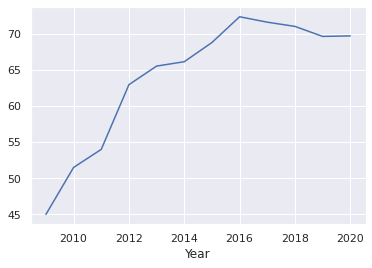

In [120]:
##looking at the above graph year looks to have no correlation or relationship with rating_final. however my gut says that isnt true. brings in domain knowledge
data_df.groupby('Year')['rating_final'].mean().plot() ##the below plot shows how there is a relationship between the mean rating by age and that the variable can be usefull in a model.
#also looking at the graph a polynomalia model may be more suitable rather then a liner model

In [119]:
data_df['horse_age'] = 2023 - data_df['Year']
data_df.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,median_trainer_price,count_trainer_price,final_sale_price_est,horse_age
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN,NaN,NaN,6160.0,5
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0,4400.0,4725.0,5.0,4725.0,3
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0,NaN,NaN,NaN,44100.0,4
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0,NaN,35000.0,8.0,52500.0,4
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0,4400.0,5170.0,10.0,7096.5,4


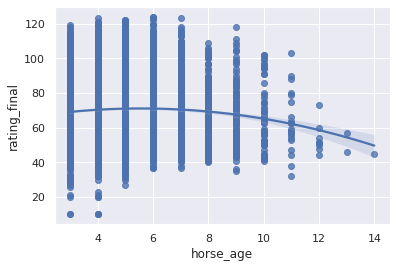

In [125]:
sns.regplot(data = data_df, x = 'horse_age', y = 'rating_final', order = 2) # an order 2 regression model fets the data better. 

In [126]:
##person correltaion stats.
def pearson_r(x,y):
    ##"""Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef([x,y])

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient for I. versicolor: r
data_df_no_nans = data_df.loc[~(data_df['horse_age'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['horse_age'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation now. will be the most of this project I suspect. 
#tiny correlation not neccesaryily one to include really even after the order 2

-0.009039925086955811


#Trainers Horses/Trainer Size


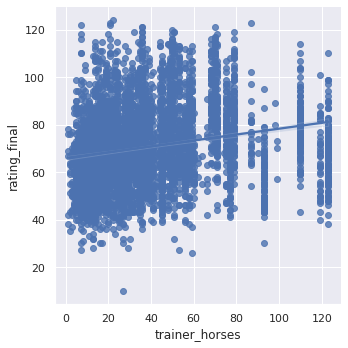

In [127]:
##eda of new final_sale_price_est column without outliers
sns.lmplot(data = data_df, x = 'trainer_horses', y = 'rating_final') 

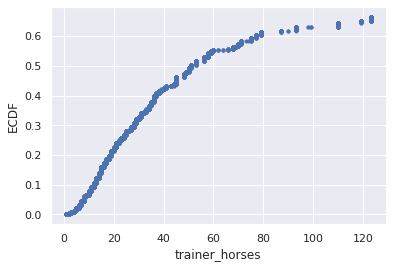

In [128]:
# Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(data['trainer_horses'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('trainer_horses')
plt.ylabel('ECDF')

# Display the plot
plt.show()

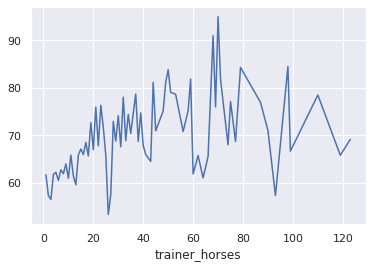

In [129]:
data_df.groupby('trainer_horses')['rating_final'].mean().plot() ##again order 2 looks a more suitable model for this relationship

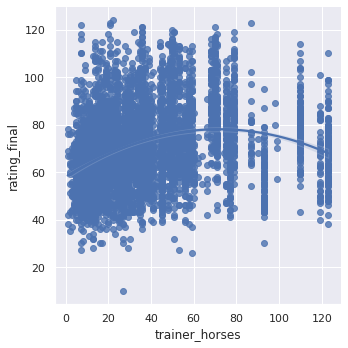

In [130]:
##eda of new final_sale_price_est column without outliers
sns.lmplot(data = data_df, x = 'trainer_horses', y = 'rating_final', order = 2) ##again order 

In [132]:
# Compute Pearson correlation coefficient
data_df_no_nans = data_df.loc[~(data_df['trainer_horses'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['trainer_horses'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation now. will be the most of this project I suspect.
#positive correlation but that would have been a linear model. could do with fitting an order 2 model.

0.20347461827702526


#Sex - Categorical Variable

In [ ]:
data[['FILLY', 'GELDING']] = pd.get_dummies(data['Sex'], drop_first = True)
data.head()

In [ ]:
data_df = data_df[['rating_final', 'Year', 'trainer_horses', 'runs', 'final_price', 'Sire_median_yearling_price', 'FILLY', 'GELDING']].dropna()

In [ ]:
##ecf function taken from datacamp module
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y
  
  # Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(data['final_price'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('Final Price')
plt.ylabel('ECDF')

# Display the plot
plt.show()

In [ ]:
sns.lmplot(data = data, x = 'runs', y = 'rating_final')

In [ ]:
sns.lmplot(data = data, x = 'Year', y = 'rating_final') ## this will need a better model/visualisation 2022 should be a touch below 2019 and 2018

In [ ]:
###will prob have to bring in scaling - does this bring in a linear relationship? so far variables are not linear

In [ ]:
####to do
##fit non linear models using ecdf function to get the best order of the polynomial models. 
##look into the best model. scaling might be better, i think if you fit a poynomial model the order is fixed for all variables.

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
y = data_df['rating_final']
X = data_df[['Year', 'trainer_horses', 'runs', 'final_price', 'Sire_median_yearling_price', 'FILLY', 'GELDING']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))
print(reg.coef_)

In [ ]:
# Import mean_squared_error
from sklearn.metrics import mean_squared_error

# Compute R-squared
r_squared = reg.score(X_test, y_test)

# Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

In [ ]:
# Import the necessary modules
from sklearn.model_selection import KFold, cross_val_score

# Create a KFold object
kf = KFold(n_splits=6, shuffle=True, random_state=5)

reg = LinearRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=kf)

# Print scores
print(cv_scores)

In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')
# path = '/content/drive/My Drive/output_fee_data_2.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   fee_data.to_csv(f)

###very handy bit of code.

In [ ]:
#i think the goal here will be to predict 2023 stallion prices based on 2022 sales results, horses abilitie and 2022 fee? stud could be good too, just trying to flesh it out a bit. might get the basic sracper out if needing more data 
#we will use the 2021 sale data and whatever horses we have from 2021 to predict 2022 prices then use the findings to predict 2023 prices.  

##another goal and one to defo do is get trainer stable size using the rating csv. good use of groupby